In [1]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sns.set_theme(style="darkgrid")

LITTLE_CONSTANT_LOG_10_TRANSFORM = 0.001

In [2]:
pd.options.display.width = 0
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',500)

df = pd.read_csv('./../datasets/electronic_products_cleaned_dataset.csv')

temp_df = pd.DataFrame((df.isnull().sum()/df.shape[0])*100,columns=['Null value%'])
temp_df['data_type'] = df.dtypes
temp_df.T

,id,Actual_price,Discount_price,Product_availability,Condition,Currency,Country,isSale,merchant,brand,Description,Category_name,primaryCategories,name,weight_in_kg,Impression,Day,Month,Year,Week,Month_Name,Day_Name,Formatted_date,Disc_Per,Total_sale
Null value%,0.0,0.0,0.0,1.6693,9.569279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
data_type,object,float64,float64,object,object,object,object,bool,object,object,object,object,object,object,float64,int64,int64,int64,int64,int64,object,object,object,float64,float64


In [3]:
# OBTENER UN DATASET REDUCIDO

# Obtener la proporción original de productos por categoría
original_proportion = df['Category_name'].value_counts(normalize=True)

# Determinar la proporción deseada para la muestra reducida (por ejemplo, 2%)
sample_proportion = 0.02

# # Calcular el tamaño de muestra para cada categoría
samples_size = (original_proportion * sample_proportion * len(df)).astype(int)

# # Realizar muestreo estratificado
reduced_df = df.groupby('Category_name', group_keys=False).apply(lambda x: x.sample(samples_size[x.name]))

reduced_df = reduced_df.reset_index(drop=True)

# reduced_df ahora contiene el 2% de productos de cada categoría con proporciones iguales al conjunto original

# Asignar dataframe reducido al dataframe original para determinar su distribución
df = reduced_df


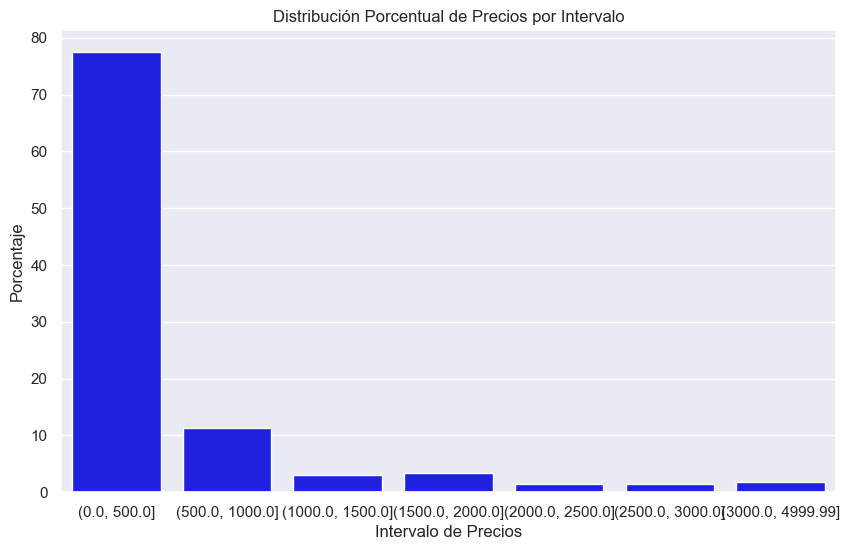

In [4]:
# DISTRIBUCIÓN PORCENTUAL DE PRECIOS CON  SESGO HACIA LA DERECHA
actual_prices = df['Actual_price']

min_value = actual_prices.min()
max_value = actual_prices.max()

# Define los límites de los intervalos (bins)
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, max_value]

# Crea categorías utilizando pd.cut
categories = pd.cut(actual_prices, bins=bins)

# Calcula la distribución porcentual
percen_distribution = categories.value_counts(normalize=True) * 100

# Visualiza la distribución porcentual
plt.figure(figsize=(10, 6))
sns.barplot(x=percen_distribution.index, y=percen_distribution.values, color='blue')
plt.title('Distribución Porcentual de Precios por Intervalo')
plt.xlabel('Intervalo de Precios')
plt.ylabel('Porcentaje')
plt.show()

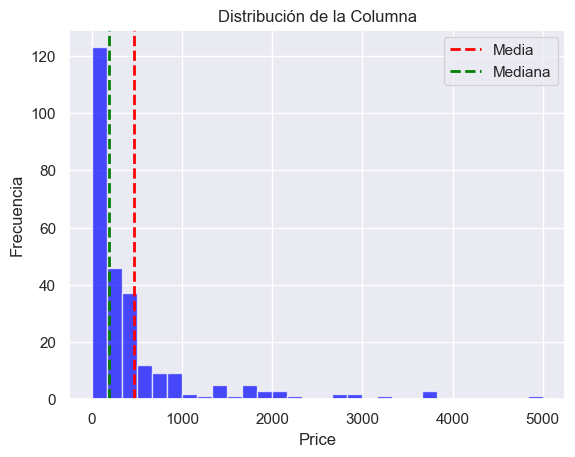

In [5]:
# Calcular estadísticas descriptivas para la columna "Actual_price" con sesgo positivo

mean = actual_prices.mean()
median = actual_prices.median()
standar_desviation = actual_prices.std()

# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(df['Actual_price'], bins=30, range=(min_value, max_value), color='blue', alpha=0.7)
plt.title('Distribución de la Columna')
plt.xlabel('Price')
plt.ylabel('Frecuencia')
plt.show()

In [6]:
# APLICAR TRANSFORMACIÓN LOGARITMICA DE BASE 10 SOBRE LA VARIABLE ACTUAL_PRICE PARA NORMALIZAR LA DISTRIBUCIÓN

actual_price_log = np.log1p(df['Actual_price'] + LITTLE_CONSTANT_LOG_10_TRANSFORM).tolist()

actual_price_log = [math.trunc(x * 100) / 100 for x in actual_price_log]
df['Actual_price_log'] = actual_price_log


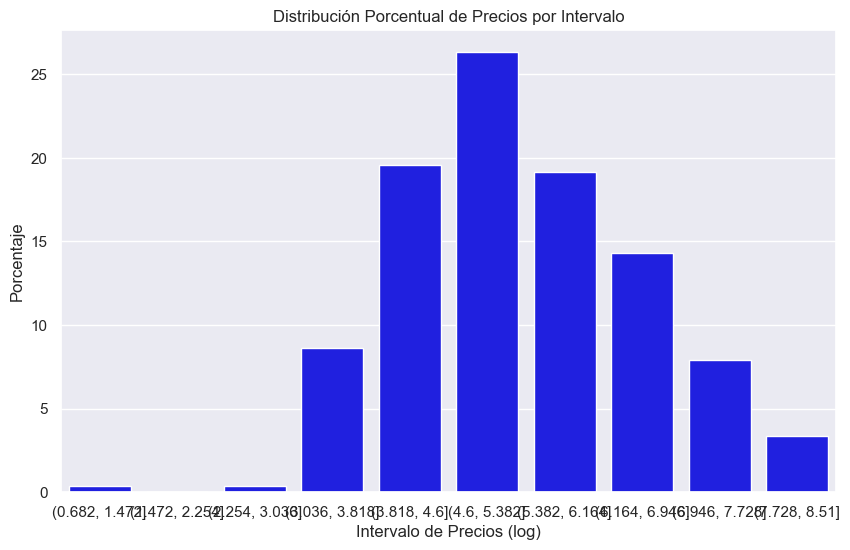

In [7]:
# DISTRIBUCIÓN PORCENTUAL DE PRECIOS DESPUES DE APLICAR TRANSFORMACIÓN LOGARITMICA DE BASE 10 SOBRE LOS PRECIOS

actual_price_log = df['Actual_price_log']

# Crea categorías utilizando pd.cut
categorias = pd.cut(actual_price_log, bins=10)

# Calcula la distribución porcentual
distribucion_porcentual = categorias.value_counts(normalize=True) * 100

# Visualiza la distribución porcentual
plt.figure(figsize=(10, 6))
sns.barplot(x=distribucion_porcentual.index, y=distribucion_porcentual.values, color='blue')
plt.title('Distribución Porcentual de Precios por Intervalo')
plt.xlabel('Intervalo de Precios (log)')
plt.ylabel('Porcentaje')
plt.show()

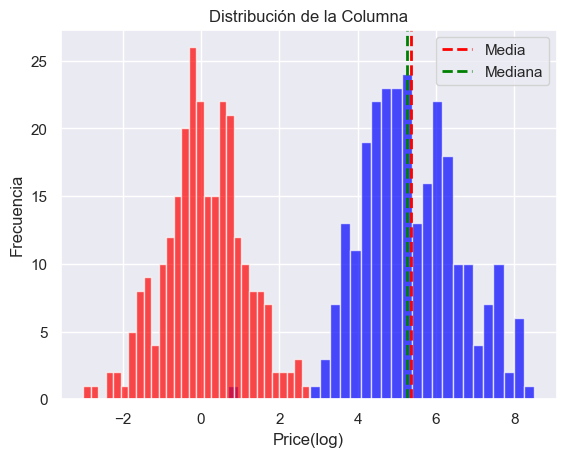

In [8]:
# Calcular estadísticas descriptivas para el precio luego de la transformación logaritmica de base 10
min_value_log = actual_price_log.min()
max_value_log = actual_price_log.max()

actual_price_log_mean = actual_price_log.mean()
actual_price_log_median = actual_price_log.median()
actual_price_log_standar_desviation = actual_price_log.std()

normal_data = np.random.normal(size=len(df['Actual_price_log']))

# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(actual_price_log_mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(actual_price_log_median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(df['Actual_price_log'], bins=30, color='blue', alpha=0.7, label='Datos transformados')
plt.hist(normal_data, bins=30, color='red', alpha=0.7, label='Distribución normal')
plt.title('Distribución de la Columna')
plt.xlabel('Price(log)')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
# TRANSFORMAR EL ATRIBUTO CUALITATIVO "brand" a CUANTITATIVO

brands_serie = df['brand']

# Estandarizo todas las marcas a minuscula
brands_serie = brands_serie.str.lower()

# Unifico las marcas duplicadas que estan escritas de distinta manera
brands_serie.replace({': polk audio': 'polk audio',
                'belkin inc.': 'belkin',
                'bose®': 'bose',
                'buffalo technology': 'buffalo',
                'cerwin vega': 'cerwin-vega',
                'cobra electronics': 'cobra',
                'denon - heos': 'denon',
                'insignia™': 'insignia',
                'jvcm': 'jvc',
                'kanto': 'kanto living',
                'klipsch xr8i in-ear headphones': 'klipsch',
                'master dynamic': 'master & dynamic',
               'motorola home': 'motorola', 
                'mtx audio': 'mtx',
                'panamx': 'panamax', 
                'pro-ject': 'pro-ject audio systems',
                'pyle pro': 'pyle', 'pylehome': 'pyle',
                'startech.com': 'startech', 'vizio, inc': 'vizio'
        }, inplace=True)

# # Anexo la serie en el dataframe original
df['brand_standarized'] = brands_serie

# Obtengo el precio promedio por marca
actual_price_mean_grouped_by_brand = df.groupby("brand_standarized")["Actual_price"].mean().reset_index()
actual_price_mean_grouped_by_brand.columns = ['brand_standarized', 'Actual_price_mean_by_brand']

actual_price_meand_by_brand_serie = actual_price_mean_grouped_by_brand['Actual_price_mean_by_brand']
actual_price_meand_by_brand_serie = [math.trunc(x * 100) / 100 for x in actual_price_meand_by_brand_serie]
actual_price_mean_grouped_by_brand['Actual_price_mean_by_brand'] = actual_price_meand_by_brand_serie

df = pd.merge(df, actual_price_mean_grouped_by_brand, on='brand_standarized', how='left')

In [10]:
# ENCODING BRAND COLUMN USING K-FOLD TARGET ENCODING

brand_standarized = df['brand_standarized'].to_numpy().reshape(-1, 1)
actual_price_mean_grouped_by_brand = df['Actual_price_mean_by_brand'].to_numpy()

# Agregar algo de ruido para evitar codificaciones exactas, esto es util cuando hay valores iguales en la
# variable target
actual_price_mean_grouped_by_brand_noisy = actual_price_mean_grouped_by_brand + np.random.normal(0, 0.01, size=actual_price_mean_grouped_by_brand.size)

# Crear una columna temporal para almacenar las codificaciones k-fold
df['brand_encoded'] = 0.0

te = TargetEncoder(target_type="continuous", smooth=2.0, shuffle=False)
brand_encoded = te.fit_transform(brand_standarized, actual_price_mean_grouped_by_brand_noisy)
brand_encoded = te.transform(brand_standarized)

combined_array=np.column_stack((te.categories_[0],te.encodings_[0]))
encoding_df = pd.DataFrame(combined_array, columns=["Categories", "Encodings"])
# print(encoding_df[['Categories','Encodings']][encoding_df['Categories'].duplicated()])
# print(encoding_df.sort_values(by=['Encodings']))

df['brand_encoded'] = brand_encoded[:, 0]

print(df[['brand_standarized', 'brand_encoded']].brand_encoded.unique().size)

# Agregar la columna codificada al dataset de entrenamiento

102


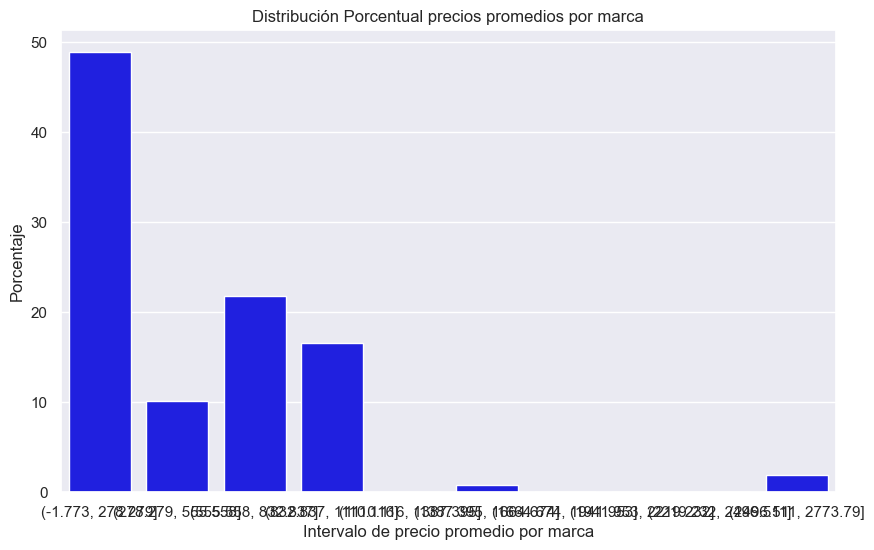

In [11]:
# DISTRIBUCIÓN PORCENTUAL DEL PRECIO PROMEDIO  POR MARCA
actual_price_mean_by_brand = df['Actual_price_mean_by_brand']

# Crea categorías utilizando pd.cut
categorias = pd.cut(actual_price_mean_by_brand, bins=10)

# Calcula la distribución porcentual
distribucion_porcentual = categorias.value_counts(normalize=True) * 100

# Visualiza la distribución porcentual
plt.figure(figsize=(10, 6))
sns.barplot(x=distribucion_porcentual.index, y=distribucion_porcentual.values, color='blue')
plt.title('Distribución Porcentual precios promedios por marca')
plt.xlabel('Intervalo de precio promedio por marca')
plt.ylabel('Porcentaje')
plt.show()

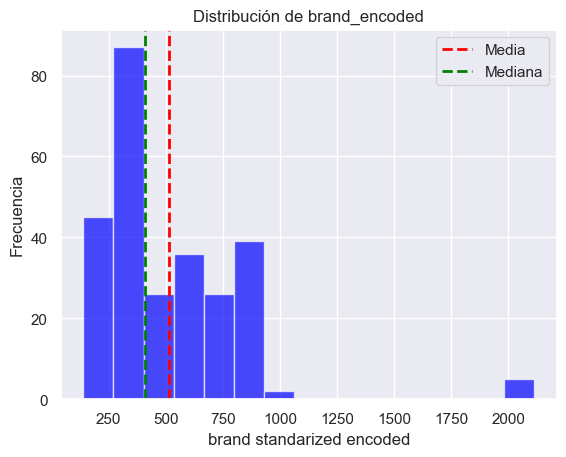

In [12]:
# Estadisticas descriptivas de las marcas codificadas
brand_encoded = df['brand_encoded']
brand_encoded_mean = brand_encoded.mean()
brand_encoded_median = brand_encoded.median()
brand_encoded_standar_desviation = brand_encoded.std()

# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(brand_encoded_mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(brand_encoded_median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(brand_encoded, bins=15, color='blue', alpha=0.7, label='Marca codificada')
plt.title('Distribución de brand_encoded')
plt.xlabel('brand standarized encoded')
plt.ylabel('Frecuencia')
plt.show()

In [13]:
# Dado al sesgo positivo, aplico transformación logaritmica para suavizar la cola derecha
df['brand_encoded_log'] = np.log1p(df['brand_encoded'] + LITTLE_CONSTANT_LOG_10_TRANSFORM).tolist()
brand_encoded_log = df['brand_encoded_log']

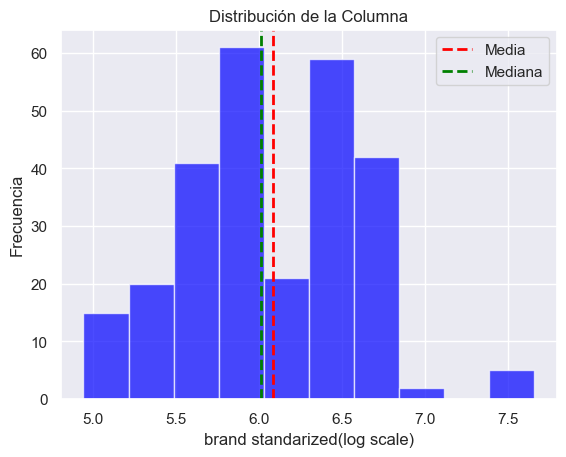

In [14]:
# Calcular estadísticas descriptivas para la marca codificada

min_value_log = brand_encoded_log.min()
max_value_log = brand_encoded_log.max()


brand_encoded_mean = brand_encoded_log.mean()
brand_encoded_median = brand_encoded_log.median()
brand_encoded_standar_desviation = brand_encoded_log.std()


# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(brand_encoded_mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(brand_encoded_median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(brand_encoded_log, bins=10, color='blue', alpha=0.7, label='Datos codificados')
plt.title('Distribución de la Columna')
plt.xlabel('brand standarized(log scale)')
plt.ylabel('Frecuencia')
plt.show()

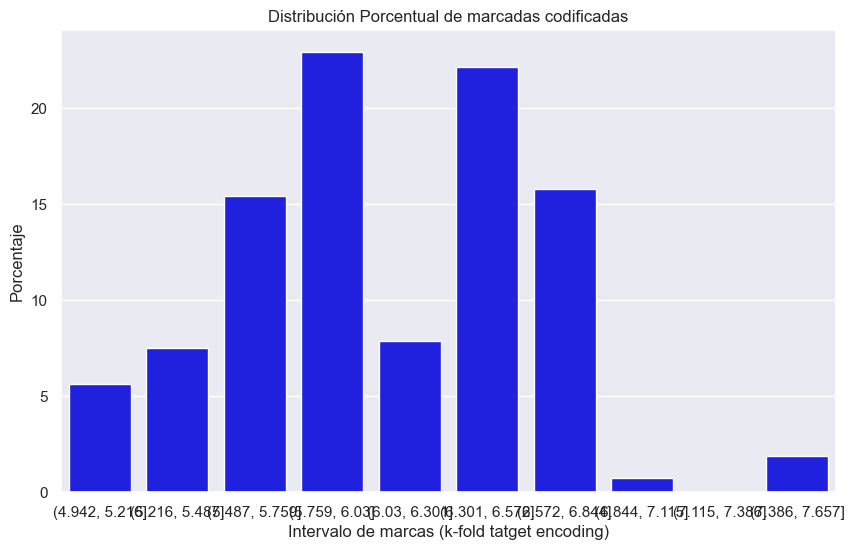

In [15]:
# DISTRIBUCIÓN PORCENTUAL DE MARCAS CODIFICADAS

# Crea categorías utilizando pd.cut
categorias = pd.cut(brand_encoded_log, bins=10)

# Calcula la distribución porcentual
distribucion_porcentual = categorias.value_counts(normalize=True) * 100

# Visualiza la distribución porcentual
plt.figure(figsize=(10, 6))
sns.barplot(x=distribucion_porcentual.index, y=distribucion_porcentual.values, color='blue')
plt.title('Distribución Porcentual de marcadas codificadas')
plt.xlabel('Intervalo de marcas (k-fold tatget encoding)')
plt.ylabel('Porcentaje')
plt.show()

In [16]:
# Guardar en archivo csv 
df.to_csv('./../datasets/reduced_electronic_products.csv', index = True) 